# Sentiment Analysis pada Ulasan Redenominasi Rupiah RI, 2026

Redenominasi adalah proses penyederhanaan nilai nominal mata uang dengan menghilangkan beberapa angka nol dari nominal tanpa menghilangkan nilai aslinya/daya belinya. Jadi, meskipun nominal berubah, nilai uang tetap sama. Misalnya dari yang awalnya Rp 100.000, setelah redenominasi menjadi Rp 100 (dikurangi 3 nol) dan daya belinya tetap sama. <br>

Baru-baru saja MenKeu RI, Purbaya Sadhewa mengumumkan adanya rencana redenominasi rupiah dengan tujuan menyederhanakan sistem transaksi dan pembukuan keuangan. Selain itu, juga menumbuhkan rasa percaya dari investor asing. Rencana ini mendapat berbagai bentuk sentiment dari masyarakat. Ada yang langsung menunjukkan respon positif namun ada juga yang menolak. <br>

Salah satu YouTuber terkenal Indonesia, Raymond Chin, mengulas terkait rancangan ini di kanal YouTubenya. Video yang diunggah pada Selasa, 11 November 2025 itu langsung mendapatkan berbagai sentiment dari masyarakat Indonesia. <br>

Projek sentiment analysis ini bertujuan untuk mengetahui seberapa besar presentase perbandingan sentiment masyarakat terhadap rencana redenominasi rupiah RI. Melalui proyek ini, kita bisa tahu apakah masyarakat cenderung menerima atau justru menolak kebijakan tersebut.

In [25]:
# KEBUTUHAN UMUM
import pandas as pd
import numpy as np
import pickle

# KEBUTUHAN PREPROCESSING TEKS
import re
import string
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.tokenize import  word_tokenize
from nltk.corpus import stopwords

!pip install Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# KEBUTUHAN LABELING
import csv
import requests
from io import StringIO

# KEBUTUHAN VISUALISASI DAN EKSPLORASI LABEL
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import  WordCloud

# KEBUTUUHAN FITUR EXTRACTION DAN MODELLING
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import  LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from xgboost import  XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# COZY CODING
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Exploratory Data Analysis

In [26]:
df = pd.read_csv('redenominasi.csv')
df.head()

,Unnamed: 0,publisedAt,username,commentDisplay
0,0,2025-12-16T10:18:19Z,@fahadchannelserbaguna7644,Sisi negatif nya ini akan terjadi inflasi gede...
1,1,2025-12-15T18:50:25Z,@LOLOLOL1703,"Intinya ada yg ketar ketir, jalankan dlu pasti..."
2,2,2025-12-15T07:30:13Z,@SatuBait,Kalau di US kan masih pakai pecahan cent untuk...
3,3,2025-12-14T14:22:28Z,@Jesa_Putra,"Kalo di zaman sekarang , lebih bisa . Meski SD..."
4,4,2025-12-14T09:57:47Z,@agussunind,"Dulu itu Pemotongan nilai mata uang,... tapi r..."


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3196 entries, 0 to 3195
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      3196 non-null   int64 
 1   publisedAt      3196 non-null   object
 2   username        3196 non-null   object
 3   commentDisplay  3196 non-null   object
dtypes: int64(1), object(3)
memory usage: 100.0+ KB


In [28]:
# Cek dimensi data
df.shape

(3196, 4)

In [29]:
# cek missing value
df.isnull().sum()

,0
Unnamed: 0,0
publisedAt,0
username,0
commentDisplay,0


In [30]:
# cek duplikat
df.duplicated().sum()

np.int64(0)

**Penjelasan :**
Data bersih dari missing value dan duplikat. Selanjutnya pilih feature yang akan digunakan: <br>

1. publishedAt
2. username
3. commentDisplay

In [31]:
df = df.drop(columns=['Unnamed: 0'])
df.head()

,publisedAt,username,commentDisplay
0,2025-12-16T10:18:19Z,@fahadchannelserbaguna7644,Sisi negatif nya ini akan terjadi inflasi gede...
1,2025-12-15T18:50:25Z,@LOLOLOL1703,"Intinya ada yg ketar ketir, jalankan dlu pasti..."
2,2025-12-15T07:30:13Z,@SatuBait,Kalau di US kan masih pakai pecahan cent untuk...
3,2025-12-14T14:22:28Z,@Jesa_Putra,"Kalo di zaman sekarang , lebih bisa . Meski SD..."
4,2025-12-14T09:57:47Z,@agussunind,"Dulu itu Pemotongan nilai mata uang,... tapi r..."


## Preprocessing Text

### Cleaning Text

In [32]:
# FUNGSI CLEANING TEXT
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) #hapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) #hapus hashtag
    text = re.sub(r'RT[\s]', '', text) #hapus RT
    text = re.sub(r'RW[\s]', '', text) #hapus RW
    text = re.sub(r"http\S+", '', text) #hapus link
    text = re.sub(r'[0-9]+', '', text) #hapus angka
    text = re.sub(r'[^\w\s]', '', text) #hapus karakter selain huruf dan angka
    text = text.replace('\n', ' ') #ganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) #hapus semua tanda baca
    text = text.strip(' ') #hapus karakter spasi dari kiri dan kanan teks
    return text

# FUNGSI CASE FOLDING
def caseFolding(text):
    text = text.lower()
    return text

# FUNGSI HANDLING SLANK
slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal", "d": "di", "gak": "tidak", "medsos": "media sosial", "pd": "pada", "ga": "tidak", "mslh": "masalah", "santuy": "santai", "trus": "terus", "yg": "yang", "oke": "baik", "kasi": "kasih", "gw": "saya", "wapres": "wakil presiden", "kepingin": "ingin", "auto": "otomatis", "utk": "untuk", "bbrp" : "beberapa", "dri": "dari", "org2": "orang-orang", "ancur": "hancur", "spt": "seperti", "bgt": "banget", "btw": "ngomong-ngomong", "anjir": "kaget", "anjay": "takjub","busyeet": "busyet","dach": "deh","ga": "tidak","gak": "tidak","gpp": "tidak apa-apa","gw": "saya","loe": "kamu","lu": "kamu","maen": "main","nggak": "tidak","ngga": "tidak","nyimak": "menyimak","sumpah": "serius","wkwk": "tertawa","wk": "tertawa","yoi": "iya","dgn": "dengan","sampe": "sampai","tdk": "tidak","kalo": "kalau","om": "paman","loh": "ekspresi heran","yaaa": "ya","org": "orang",}
def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

# FUNGSI TOKENISASI
def tokenizingText(text):
    text = word_tokenize(text)
    return  text

# STOPWORDS HANDLING
def stopwordsText(text):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy", 'gk', 'cuy', 'dih', 'beuh', 'eee', 'heee', 'nih', 'nihh', 'dong', 'mulu', 'mah', ])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

# FUNGSI STEMMING TEKS
def stemmingText(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    #Stemming setiap kata
    stemmed_words = [stemmer.stem(word) for word in text]

    #Gabung kata yang telah distem dengan spasi
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

# SIMPAN NASKAH AKHIR
def toSentence(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

In [33]:
 # IMPLEMENTASI FUNGSI
# Bersihkan teks dg regex
df['text_clean'] = df['commentDisplay'].apply(cleaningText)

# Case folding
df['text_caseFolding'] = df['text_clean'].apply(caseFolding)

# Slang Handling
df['text_slangWords'] = df['text_caseFolding'].apply(fix_slangwords)

# Tokenisasi
df['text_tokenizing'] = df['text_slangWords'].apply(tokenizingText)

# Stopwords Handling
df['text_stopwords'] = df['text_tokenizing'].apply(stopwordsText)

# Join text
df['text_final'] = df['text_stopwords'].apply(toSentence)

df.head()

,publisedAt,username,commentDisplay,text_clean,text_caseFolding,text_slangWords,text_tokenizing,text_stopwords,text_final
0,2025-12-16T10:18:19Z,@fahadchannelserbaguna7644,Sisi negatif nya ini akan terjadi inflasi gede...,Sisi negatif nya ini akan terjadi inflasi gede...,sisi negatif nya ini akan terjadi inflasi gede...,sisi negatif nya ini akan terjadi inflasi gede...,"[sisi, negatif, nya, ini, akan, terjadi, infla...","[sisi, negatif, inflasi, gedeanquot]",sisi negatif inflasi gedeanquot
1,2025-12-15T18:50:25Z,@LOLOLOL1703,"Intinya ada yg ketar ketir, jalankan dlu pasti...",Intinya ada yg ketar ketir jalankan dlu pasti ...,intinya ada yg ketar ketir jalankan dlu pasti ...,intinya ada yang ketar ketir jalankan dlu past...,"[intinya, ada, yang, ketar, ketir, jalankan, d...","[intinya, ketar, ketir, jalankan, dlu, sdh, di...",intinya ketar ketir jalankan dlu sdh dipikirka...
2,2025-12-15T07:30:13Z,@SatuBait,Kalau di US kan masih pakai pecahan cent untuk...,Kalau di US kan masih pakai pecahan cent untuk...,kalau di us kan masih pakai pecahan cent untuk...,kalau di us kan masih pakai pecahan cent untuk...,"[kalau, di, us, kan, masih, pakai, pecahan, ce...","[us, pakai, pecahan, cent, mata, uang, recehan...",us pakai pecahan cent mata uang recehan indo p...
3,2025-12-14T14:22:28Z,@Jesa_Putra,"Kalo di zaman sekarang , lebih bisa . Meski SD...",Kalo di zaman sekarang lebih bisa Meski SDM ...,kalo di zaman sekarang lebih bisa meski sdm ...,kalau di zaman sekarang lebih bisa meski sdm r...,"[kalau, di, zaman, sekarang, lebih, bisa, mesk...","[zaman, sdm, rendah, konsisten, sosialisasi, e...",zaman sdm rendah konsisten sosialisasi eksekus...
4,2025-12-14T09:57:47Z,@agussunind,"Dulu itu Pemotongan nilai mata uang,... tapi r...",Dulu itu Pemotongan nilai mata uang tapi redem...,dulu itu pemotongan nilai mata uang tapi redem...,dulu itu pemotongan nilai mata uang tapi redem...,"[dulu, itu, pemotongan, nilai, mata, uang, tap...","[pemotongan, nilai, mata, uang, redemonasi, ni...",pemotongan nilai mata uang redemonasi nilai no...


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3196 entries, 0 to 3195
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   publisedAt        3196 non-null   object
 1   username          3196 non-null   object
 2   commentDisplay    3196 non-null   object
 3   text_clean        3196 non-null   object
 4   text_caseFolding  3196 non-null   object
 5   text_slangWords   3196 non-null   object
 6   text_tokenizing   3196 non-null   object
 7   text_stopwords    3196 non-null   object
 8   text_final        3196 non-null   object
dtypes: object(9)
memory usage: 224.8+ KB


### Labelling Text (Polarisasi)

In [35]:
positive = {
    'baik', 'bagus', 'lancar', 'menyederhanakan', 'sederhana', 'jelas', 'mudah', 'dukung', 'teliti', 'investasi', 'berhasil', 'cepat', 'bermanfaat', 'berguna', 'setuju', 'matang', 'menguntungkan', 'trust', 'optimis', 'gampang', 'positif', 'terima', 'kasih', 'sosialisasi', 'dukung', 'paham', 'mengerti', 'bangkit', 'emas', 'efisien', 'efektif', 'tinggi', 'invest', 'menstimulus', 'stimulus', 'menguat', 'sukses', 'semangat', 'bermartabat', 'cerdas', 'pinter', 'terealisasi', 'pemberantasan', 'media', 'sosial', 'setuju', 'sekali', 'percaya', 'nyaman', 'maju', 'mantap', 'edukasi', 'semoga', 'tunggu', 'aman', 'perbaiki', 'super', 'menyenangkan', 'good', 'luck'
}

negative = {
    'tidak', 'gagal', 'pesimis', 'sulit', 'susah', 'miskin', 'berisiko', 'parah', 'bodoh', 'rendah', 'lemah', 'palsu', 'serakah', 'negatif', 'bohong', 'egois', 'koruptor', 'korupsi', 'becus', 'muak', 'jangan', 'inflasi', 'resiko', 'tolak', 'blunder', 'bingung', 'bobrok', 'jahat', 'morat', 'marit', 'membagongkan', 'buang', 'aneh', 'bernilai', 'tamak', 'sembrono', 'korup', 'korupsi', 'misleading', 'males', 'kacung', 'terganggu', 'ganggu', 'keras', 'takut', 'mumet', 'payah', 'dikit', 'ancaman', 'sanering', 'ketakutan', 'takut', 'salah', 'tikus', 'nakutin', 'murahan', 'utang', 'dikit', 'bodo', 'hancur', 'receh', 'gimana', 'ketinggalan'
}

# Fungsi klasifikasi sentiment (0 = negatif, 1 = netral, 2 = positif)
def classify_sentiment(texts):
    texts = texts.lower()

    if any(kata in texts for kata in positive):
        return 2
    elif any(kata in texts for kata in negative):
        return  0
    else:
        return 1

df['Sentiment'] = df['text_final'].apply(classify_sentiment)
print("Distribusi label: ", np.bincount(df['Sentiment']))
df[['text_final', 'Sentiment']].head().style.hide(axis='index')

Distribusi label:  [ 701 1065 1430]


text_final,Sentiment
sisi negatif inflasi gedeanquot,0
intinya ketar ketir jalankan dlu sdh dipikirkan matang,2
us pakai pecahan cent mata uang recehan indo penasaran nunggu,0
zaman sdm rendah konsisten sosialisasi eksekusi meminimalisir kegagalan timing menentukan hasil lepas oknum nakal,2
pemotongan nilai mata uang redemonasi nilai nol beda,1


In [36]:
print(df['Sentiment'].value_counts())

Sentiment
2    1430
1    1065
0     701
Name: count, dtype: int64


In [37]:
# Ubah hasil polarisasi ke kata
sentiment_mapp = {
    0 : 'Negative',
    1 : 'Neutral',
    2 : 'Positive'
}

df['Sentiment_Label'] = df['Sentiment'].map(sentiment_mapp)
df[['text_final', 'Sentiment', 'Sentiment_Label']].head(10)

,text_final,Sentiment,Sentiment_Label
0,sisi negatif inflasi gedeanquot,0,Negative
1,intinya ketar ketir jalankan dlu sdh dipikirka...,2,Positive
2,us pakai pecahan cent mata uang recehan indo p...,0,Negative
3,zaman sdm rendah konsisten sosialisasi eksekus...,2,Positive
4,pemotongan nilai mata uang redemonasi nilai no...,1,Neutral
5,keren bang malasiya aja orang malaysia kaget g...,2,Positive
6,indomaret punten rupiahnya didonasikan,1,Neutral
7,sosmed sosmed beda,1,Neutral
8,menariq,1,Neutral
9,bapak² pasar hewan beli kambing sapi,1,Neutral


In [38]:
# SIMPAN HASIL
df.to_csv('redenominasi_polarited.csv')

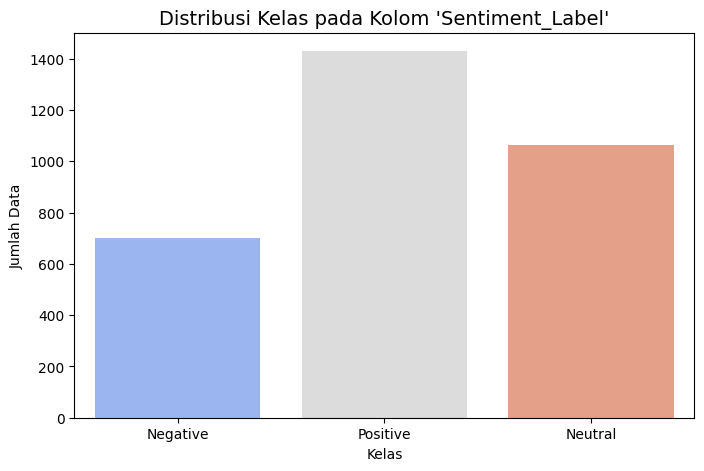

In [39]:
column_name = 'Sentiment_Label'

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x=column_name, palette='coolwarm')

plt.title(f"Distribusi Kelas pada Kolom '{column_name}'", fontsize=14)
plt.xlabel("Kelas")
plt.ylabel("Jumlah Data")
plt.show()

### Ekstraksi Fitur

In [40]:
X = df['text_final']
y = df['Sentiment']

In [41]:
# Menggunakan metode BoW (Bag of Words)
bow = CountVectorizer()
X_bow = bow.fit_transform(X)

### Model Building

In [42]:
def eval_model_cv(model, X, y, cv_splits=5):
    cv = StratifiedKFold(n_splits=5, shuffle=True,random_state=42)

    y_pred = cross_val_predict(model, X, y, cv=cv)

    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='weighted')
    recall = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')

    # Print hasil
    print(f"========= Evaluasi Model ==========")
    print(f"Accuracy train: {accuracy:.4f}")
    print(f"Accuracy test: {accuracy}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1_Score: {f1:4f}")
    print("==================================================\n")

#### Random Forest

In [43]:
# BoW
rf = RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100)
eval_model_cv(rf, X_bow, y, cv_splits=5)

========= Evaluasi Model ==========
Accuracy train: 0.8404
Accuracy test: 0.8404255319148937
Precision: 0.8536
Recall: 0.8404
F1_Score: 0.839575



#### Decision Tree

In [46]:
dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)
eval_model_cv(dt, X_bow, y, cv_splits=5)

========= Evaluasi Model ==========
Accuracy train: 0.8126
Accuracy test: 0.8125782227784731
Precision: 0.8233
Recall: 0.8126
F1_Score: 0.812028



#### Logistic Regression

In [47]:
lr = LogisticRegression(class_weight='balanced', random_state=42)
eval_model_cv(lr, X_bow, y, cv_splits=5)

========= Evaluasi Model ==========
Accuracy train: 0.8326
Accuracy test: 0.8326032540675845
Precision: 0.8451
Recall: 0.8326
F1_Score: 0.831827



#### SVM

In [48]:
svm = SVC(class_weight='balanced', random_state=42)
eval_model_cv(svm, X_bow, y, cv_splits=5)

========= Evaluasi Model ==========
Accuracy train: 0.7778
Accuracy test: 0.7778473091364205
Precision: 0.7860
Recall: 0.7778
F1_Score: 0.775133



#### XGBoost

In [49]:
xgb = XGBClassifier(
    max_depth=5,
    learning_rate=0.3,
    n_estimators=100,
    objective='multi:softprob'
)

eval_model_cv(xgb, X_bow, y, cv_splits=5)

========= Evaluasi Model ==========
Accuracy train: 0.8545
Accuracy test: 0.85450563204005
Precision: 0.8691
Recall: 0.8545
F1_Score: 0.854056



### WordCloud

In [44]:
# Fit model
rf.fit(X_bow, y)

RandomForestClassifier(class_weight='balanced', random_state=42)

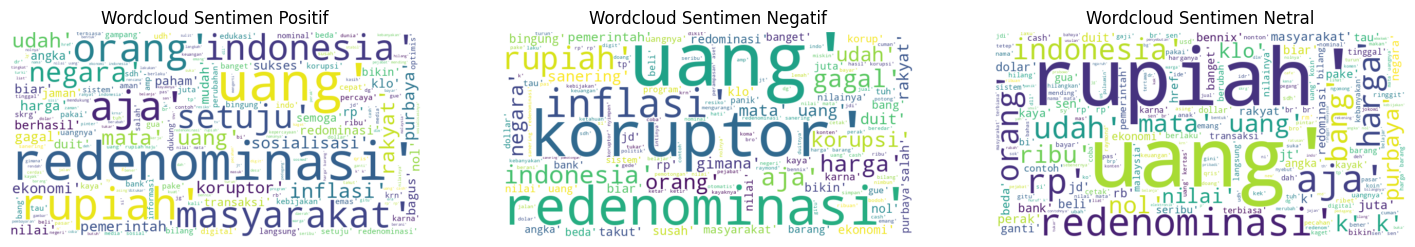

In [45]:
# Prediksi sentimen untuk seluruh komentar
X_new = bow.transform(X)
predictions = rf.predict(X_new)

# Tambahkan prediksi ke dataframe
df['Predicted_Sentiment'] = predictions

# Pisahkan data berdasarkan prediksi sentimen
df_positive_pred = df[df['Predicted_Sentiment'] == 2]  # Sentimen positif
df_negative_pred = df[df['Predicted_Sentiment'] == 0]  # Sentimen negatif
df_neutral_pred = df[df['Predicted_Sentiment'] == 1]  # Sentimen netral

# Gabungkan semua komentar menjadi satu string
positive_text = " ".join(df_positive_pred['text_stopwords'].astype(str))
negative_text = " ".join(df_negative_pred['text_stopwords'].astype(str))
neutral_text = " ".join(df_neutral_pred['text_stopwords'].astype(str))

wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_text)
wordcloud_neutral = WordCloud(width=800, height=400, background_color='white').generate(neutral_text)

# Show
plt.figure(figsize=(18, 10))

plt.subplot(1, 3, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis("off")
plt.title("Wordcloud Sentimen Positif")

plt.subplot(1, 3, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis("off")
plt.title("Wordcloud Sentimen Negatif")

plt.subplot(1, 3, 3)
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.axis("off")
plt.title("Wordcloud Sentimen Netral")

plt.show()

Demo

In [50]:
pip install gradio

In [55]:
import gradio as gr

# Pastikan semua fungsi preprocessing sudah tersedia dari sel sebelumnya
# cleaningText, caseFolding, fix_slangwords, tokenizingText, stopwordsText, toSentence

# Pastikan model `rf` dan vectorizer `bow` sudah dilatih dan tersedia
# rf = RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100)
# rf.fit(X_bow, y)
# bow = CountVectorizer()
# X_bow = bow.fit_transform(X)

# Fungsi prediksi sentimen
def predict_sentiment(text):
    # Preprocessing
    cleaned_text = cleaningText(text)
    casefolded_text = caseFolding(cleaned_text)
    slang_fixed_text = fix_slangwords(casefolded_text)
    tokenized_text = tokenizingText(slang_fixed_text)
    stopwords_removed_text = stopwordsText(tokenized_text)
    final_text = toSentence(stopwords_removed_text)

    # Transformasi fitur
    X_new = bow.transform([final_text])

    # Prediksi
    prediction = rf.predict(X_new)[0]

    # Konversi label numerik ke string sentimen
    sentiment_labels = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    return sentiment_labels[prediction]

# Membuat antarmuka Gradio
iface = gr.Interface(
    fn=predict_sentiment,
    inputs=gr.Textbox(lines=5, label="Masukkan komentar Anda"),
    outputs=gr.Textbox(label="Prediksi Sentimen"),
    title="Analisis Sentimen Ulasan Redenominasi Rupiah",
    description="Masukkan komentar terkait redenominasi rupiah untuk memprediksi sentimen (Positif, Netral, atau Negatif)."
)

# Meluncurkan aplikasi Gradio
iface.launch(debug=True)


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://d4d198106981397d50.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://03ac64430901f4ee2e.gradio.live
Killing tunnel 127.0.0.1:7860 <> https://d4d198106981397d50.gradio.live
